In [1]:
from typing import Annotated
from typing_extensions import TypedDict,List
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
import pandas as pd
import pprint
from langchain.chat_models import init_chat_model
#from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from promptstore import orderPrompt, conversationPrompt, agentPrompt
from Classes import Item, Order
from utils import makeRetriever, get_context
import warnings
import operator
warnings.filterwarnings("ignore")
import os 
from dotenv import load_dotenv
load_dotenv()
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
memory= MemorySaver()
import json

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
 

In [ ]:
parser = PydanticOutputParser(pydantic_object=Order)
menu = pd.read_csv("testmenu100.csv")


In [12]:
# from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model
# llm = ChatGroq(model="llama-3.1-8b-instant")
llm = init_chat_model("ollama:llama3.1")
orderChain = orderPrompt | llm | parser
conversationChain = conversationPrompt | llm
retriever = makeRetriever(menu, search_type="similarity", k=10)


Tools

In [13]:
@tool
def extract_order(user_input: str) -> Order:
   """
    Extracts a single, structured order JSON from user input.
    ALWAYS use this tool when the user is explicitly placing an order.
    The function must be called only once per user turn,
    and its purpose is to parse the entire user request into a single order.
    the order should be a single JSON object with the following structure:{
  "items": [
    {
      "item": "Burger",
      "quantity": 1,
      "modifiers": [
        "extra cheese"
      ]
    },
    {
      "item": "Burger",
      "quantity": 1,
      "modifiers": [
        "beef patty"
      ]
    },
    {
      "item": "Burger",
      "quantity": 1,
      "modifiers": []
    },
    {
      "item": "ginger beer",
      "quantity": 1,
      "modifiers": []
    }
  ]
}"""
   try:
        result = orderChain.invoke({
            "user_input": user_input,
            "format_instructions": parser.get_format_instructions()
        })
        return result.model_dump_json()
   except Exception as e:
        return f"Error parsing order: {str(e)}"
    
@tool
def menu_query(user_input: str) -> str:
    """Answer questions about the menu. If the user asks about the menu, this tool will be used to answer the question. Repeat the order if the user asks about the order.(Extract it from the chat history)"""
    rel_docs, context = get_context(user_input, retriever)
    ai_response = conversationChain.invoke({
        "context": context,
        "user_input": user_input,
        "chat_history": []
    })
    return ai_response.content

@tool
def order_summary(order_history: Annotated[list, list.__add__]) -> str:
    """Summarize the order. This tool summarizes the order by looking at the JSON output from the extract_order tool in the order_history. The user is asking to summarize the order or 'what did I order?'"""
    if order_history:
        
        most_recent_order = order_history[-1]
        return f"Your current order is: {most_recent_order}. Would you like to confirm this order?"
    else:
        return "No order found. Please place an order first."



In [14]:

tools = [extract_order, menu_query,order_summary]

In [15]:
llm_with_tools=llm.bind_tools(tools)


In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import FunctionMessage

def merge_orders(current_order: dict, new_order: dict) -> dict:
    """Combines a new order dictionary with the existing order dictionary."""
    if not current_order:
        return new_order
    
    # Merge logic: here we'll just add new items to the existing list.
    # You could add more complex logic here (e.g., merging quantities).
    current_order['items'].extend(new_order.get('items', []))
    
    return current_order
class State(TypedDict):
    """State of the graph, including messages and order history."""
    messages: Annotated[list, add_messages]
    order_history: Annotated[dict, merge_orders]
## Graph

def update_order_history(state: State):
    last_message = state['messages'][-1]
    
    if isinstance(last_message, FunctionMessage) and last_message.name == 'extract_order':
        # Parse the JSON string into a Python dictionary
        try:
            new_order_data = json.loads(last_message.content)
            # The combiner will merge this dictionary with the existing order_history
            return {"order_history": new_order_data}
        except json.JSONDecodeError:
            # Handle cases where the tool output is not valid JSON
            return {}
            
    return {}
## Node Condition
def tool_calling_llm(state: State):
   return {"messages": [llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("update_order_history", update_order_history)
builder.add_node("tools", ToolNode(tools))

## Edges
# Define the single, unambiguous entry point
builder.add_edge(START, "tool_calling_llm")

# Define the conditional edges from the 'tool_calling_llm'
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END,
    }
)

# Define the conditional edges from the 'tools' node
builder.add_conditional_edges(
    "tools",
    lambda state: state['messages'][-1].name == "extract_order",
    {
        True: "update_order_history",
        False: "tool_calling_llm"
    }
)

# Define the edge from the 'update_order_history' node
builder.add_edge("update_order_history", "tool_calling_llm")

# graph building and saving the memory
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

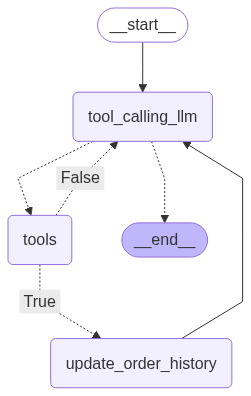

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
config={"configurable":{"thread_id":"1"}}
response=graph.invoke({'messages': 'I want a Burger and 1 shot of espresso'},config=config)
response['messages'][-1].content

'Based on the tool call output, it appears that I can fulfill your order for a burger and 1 shot of espresso. Your total comes out to be the price of a burger plus the cost of a shot of espresso.\n\nWould you like me to provide the exact prices or proceed with preparing your order?'

In [19]:
config={"configurable":{"thread_id":"1"}}
for chunk in graph.stream({'messages': ['another burger and espresso']},config=config,stream_mode="values"):
    print(chunk['messages'][-1].content)

another burger and espresso

{"items":[{"item_name":"Burger","quantity":1,"modifiers":[]},{"item_name":"Espresso","quantity":1,"modifiers":["no sugar"]}]}
Based on the tool call output, it appears that I can fulfill your order for a burger and 1 shot of espresso with no sugar. Your total comes out to be the price of a burger plus the cost of a shot of espresso without sugar.

Would you like me to proceed with preparing your order?


In [20]:
config={"configurable":{"thread_id":"1"}}
messages = ['I want 3 Burgers, 1 burger from this should have extra cheese and another should have a beef patty and ginger beer']
for chunk in graph.stream({'messages':messages },config=config,stream_mode="values"):
    print(chunk['messages'][-1].content)
    last_message = chunk['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call['name'] == 'order_summary':
                  print("The agent is calling the order_summary tool.", message=last_message.content)
                  

        if last_message.tool_calls[0]['name'] == "extract_order":
            messages.append(last_message)

I want 3 Burgers, 1 burger from this should have extra cheese and another should have a beef patty and ginger beer

{"items":[{"item_name":"Burger","quantity":2,"modifiers":["extra cheese"]},{"item_name":"Burger","quantity":1,"modifiers":["beef patty"]},{"item_name":"Burger","quantity":1,"modifiers":["no sugar"]}]}
Based on the tool call output, it appears that I can fulfill your order for 3 burgers. One burger will have extra cheese, another will have a beef patty, and the third one is regular.

I'll also include a ginger beer in your order as per your request. Your total comes out to be the price of three burgers plus the cost of a shot of espresso without sugar (which was added earlier).

Would you like me to proceed with preparing your order?


In [21]:
for chunk in graph.stream({'messages':messages },config=config,stream_mode="values"):
    for m in chunk['messages']:
        m.pretty_print()

================================ Human Message =================================

I want a Burger and 1 shot of espresso
================================== Ai Message ==================================
Tool Calls:
  extract_order (b5e43d3c-04ae-4dc2-8230-189838409878)
 Call ID: b5e43d3c-04ae-4dc2-8230-189838409878
  Args:
    user_input: I want a Burger and 1 shot of espresso
================================= Tool Message =================================
Name: extract_order

{"items":[{"item_name":"Burger","quantity":1,"modifiers":[]},{"item_name":"Espresso","quantity":1,"modifiers":[]}]}
================================== Ai Message ==================================

Based on the tool call output, it appears that I can fulfill your order for a burger and 1 shot of espresso. Your total comes out to be the price of a burger plus the cost of a shot of espresso.

Would you like me to provide the exact prices or proceed with preparing your order?
================================ Human Me